# The fonctions to import


In [9]:
import numpy as np
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
sns.set_palette('deep')



# The scraping of the funds of french private company's

In [10]:


def scrape_french_funds():
    url = 'https://www.investing.com/funds/france-funds'
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'}

    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'html.parser')

        Name = []
        Symbol = []
        Last = []
        Chg = []
        Total_Assets = []
        Time = []

        table = soup.find('table')
        if table:
            rows = table.find_all('tr')[1:]  
            for row in rows:
                cols = row.find_all('td')
                # print(f"Columns in row: {[col.text.strip() for col in cols]}") # DEBUG PRINT: Show column contents
                if len(cols) >= 8:  
                    Name.append(cols[1].text.strip())  
                    Symbol.append(cols[2].text.strip()) 
                    Last.append(cols[3].text.strip())   
                    Total_Assets.append(cols[5].text.strip()) 
                    Time.append(cols[6].text.strip())   
                    try:
                        Chg_value = float(cols[4].text.strip().replace('%', '')) 
                        Chg.append(Chg_value)
                    except ValueError:
                        Chg.append(None)
                        print(f"Warning: Could not convert '{cols[4].text.strip()}' to float for 'Chg'")

        # Create DataFrame
        df = pd.DataFrame({
            'Name': Name,
            'Symbol': Symbol,
            'Last': Last,
            'Chg': Chg,
            'Total_Assets': Total_Assets,
            'Time': Time
            })

        return df

    except Exception as e:
        print(f'Error scraping data: {e}')
        return None

df = scrape_french_funds()
print(df)

                                         Name   Symbol         Last   Chg  \
0              Amundi Euro Liquidity SRI IC C  0P0000.  249,580.888  0.01   
1              Carmignac Patrimoine A EUR Acc  0P0000.      713.930 -0.03   
2             Carmignac Patrimoine A EUR Ydis  0P0000.      116.710 -0.03   
3              Carmignac Patrimoine E EUR Acc  0P0000.      171.630 -0.03   
4          Carmignac Patrimoine A CHF Acc Hdg  0P0000.      115.010 -0.04   
..                                        ...      ...          ...   ...   
95                               ALM Offensif  0P0000.      312.050  0.56   
96              29 Haussmann Euro Rendement C  0P0000.    1,607.860  0.10   
97  Candriam Index Arbitrage Classique en EUR  0P0000.    1,518.920 -0.08   
98          BNP Paribas Actions Monde Classic  0P0000.       31.120 -0.16   
99   Natixis Ultra Short Term Bonds Plus SI C  0P0000.    1,711.680 -0.01   

   Total_Assets   Time  
0        53.84B  13/03  
1         6.07B  13/03  


# Fetch the data


In [11]:
funds_df = scrape_french_funds()

if funds_df is not None:
    print('French Companies Funds Data:')
    display(funds_df)

French Companies Funds Data:


,Name,Symbol,Last,Chg,Total_Assets,Time
0,Amundi Euro Liquidity SRI IC C,0P0000.,"249,580.888",0.01,53.84B,13/03
1,Carmignac Patrimoine A EUR Acc,0P0000.,713.930,-0.03,6.07B,13/03
2,Carmignac Patrimoine A EUR Ydis,0P0000.,116.710,-0.03,6.07B,13/03
3,Carmignac Patrimoine E EUR Acc,0P0000.,171.630,-0.03,6.07B,13/03
4,Carmignac Patrimoine A CHF Acc Hdg,0P0000.,115.010,-0.04,6.07B,13/03
...,...,...,...,...,...,...
95,ALM Offensif,0P0000.,312.050,0.56,1.12B,12/03
96,29 Haussmann Euro Rendement C,0P0000.,"1,607.860",0.10,1.3B,12/03
97,Candriam Index Arbitrage Classique en EUR,0P0000.,"1,518.920",-0.08,256.67M,13/03
98,BNP Paribas Actions Monde Classic,0P0000.,31.120,-0.16,1.36B,12/03


# Risk Analysis

In [12]:
funds_df['Risk'] = funds_df['Chg'].abs()
sorted_df = funds_df.sort_values(by='Risk', ascending=True)

print("Funds from Lowest to Highest Risk:")
display(sorted_df[['Name', 'Risk', 'Total_Assets', 'Chg']])

Funds from Lowest to Highest Risk:


,Name,Risk,Total_Assets,Chg
0,Amundi Euro Liquidity SRI IC C,0.01,53.84B,0.01
5,Carmignac Patrimoine A USD Acc Hdg,0.01,6.07B,-0.01
13,Groupama Entreprises R,0.01,6.25B,0.01
14,Groupama Entreprises N,0.01,6.25B,0.01
12,Groupama Entreprises IC,0.01,6.25B,0.01
...,...,...,...,...
85,Ofi Financial Investment - Precious Metals R,1.26,525.61M,1.26
48,H2O Multibonds FCP NEUR C,2.01,1.28B,2.01
45,H2O Multibonds FCP IEUR C,2.02,1.28B,2.02
46,H2O Multibonds FCP SREUR C,2.02,1.28B,2.02


In [13]:
# Top 5 funds with the highest returns
top5_retuns = funds_df.sort_values(by='Chg', ascending=False).head(5)[['Name', 'Chg']]

print("Top 5 Best Performing Funds (by Rate of Change):")
print(top5_retuns.to_string(index=False))

Top 5 Best Performing Funds (by Rate of Change):
                                        Name  Chg
                   H2O Multibonds FCP IEUR C 2.02
                  H2O Multibonds FCP SREUR C 2.02
                   H2O Multibonds FCP NEUR C 2.01
Ofi Financial Investment - Precious Metals R 1.26
                   H2O Multibonds FCP RUSD C 1.12


In [14]:
# Top 5 funds with the lowest risk
top5_lowest_risk = funds_df.sort_values(by='Risk', ascending=True).head(5)[['Name', 'Risk']]

print("\n Top 5 Least Risky Funds:")
print(top5_lowest_risk.to_string(index=False))


 Top 5 Least Risky Funds:
                              Name  Risk
    Amundi Euro Liquidity SRI IC C  0.01
Carmignac Patrimoine A USD Acc Hdg  0.01
            Groupama Entreprises R  0.01
            Groupama Entreprises N  0.01
           Groupama Entreprises IC  0.01


# Optimized Comparison of the French Funds

In [15]:
df = funds_df.copy()
df['Total_Assets'] = df['Total_Assets'].str.replace('B', '').str.replace('M', '').astype(float)
df['Total_Assets'] = df.apply(
    lambda x: x['Total_Assets']*1e9 if 'B' in funds_df.loc[x.name,'Total_Assets'] else x['Total_Assets']*1e6, 
    axis=1
)
df['Risk'] = df['Chg'].abs()

fig = px.scatter(
    df,
    x="Risk",
    y="Chg",
    size="Total_Assets",
    color="Risk",
    hover_name="Name",
    size_max=40,
    color_continuous_scale=px.colors.sequential.Viridis,
    labels={'Chg': 'Change Rate', 'Risk': 'Risk Level'},
    title='<b>French Funds - Optimized Comparison</b>'
)

fig.update_layout(
    hoverlabel=dict(bgcolor="white", font_size=12, font_family="Arial"),
    width=1200,
    height=800
)

# Smart label placement optimization
highlighted_funds = df[(df['Risk'] > 1) | (df['Chg'].abs() > 1)].sort_values('Risk', ascending=False)

# Dynamic offset calculation to prevent overlaps
for i, row in highlighted_funds.iterrows():
    offset_multiplier = (i % 3)  # 3 different positions
    fig.add_annotation(
        x=row['Risk'],
        y=row['Chg'],
        text=row['Name'],
        showarrow=True,
        arrowhead=1,
        ax=-30 if offset_multiplier == 0 else 30 if offset_multiplier == 1 else 0,
        ay=-40 if offset_multiplier != 2 else 40,
        font=dict(color='firebrick', size=10),
        textangle=45 if offset_multiplier == 1 else 0,
        bgcolor='rgba(255,255,255,0.8)'
    )

# Manual adjustments for specific funds
special_funds = ["BDL Convictions", "Groupama Avenir Euro"]
for name in special_funds:
    if name in df['Name'].values:
        fund_data = df[df['Name'] == name].iloc[0]
        fig.add_annotation(
            x=fund_data['Risk'],
            y=fund_data['Chg'],
            text=name,
            showarrow=True,
            arrowhead=2,
            ax=50,
            ay=-60,
            font=dict(color='darkblue', size=12, family='Arial Black'),
            bordercolor='black',
            borderwidth=1
        )

fig.show()

# ML-Driven Fund Performance Prediction


Model Performance:
- RMSE: 0.478
- R²: 0.393


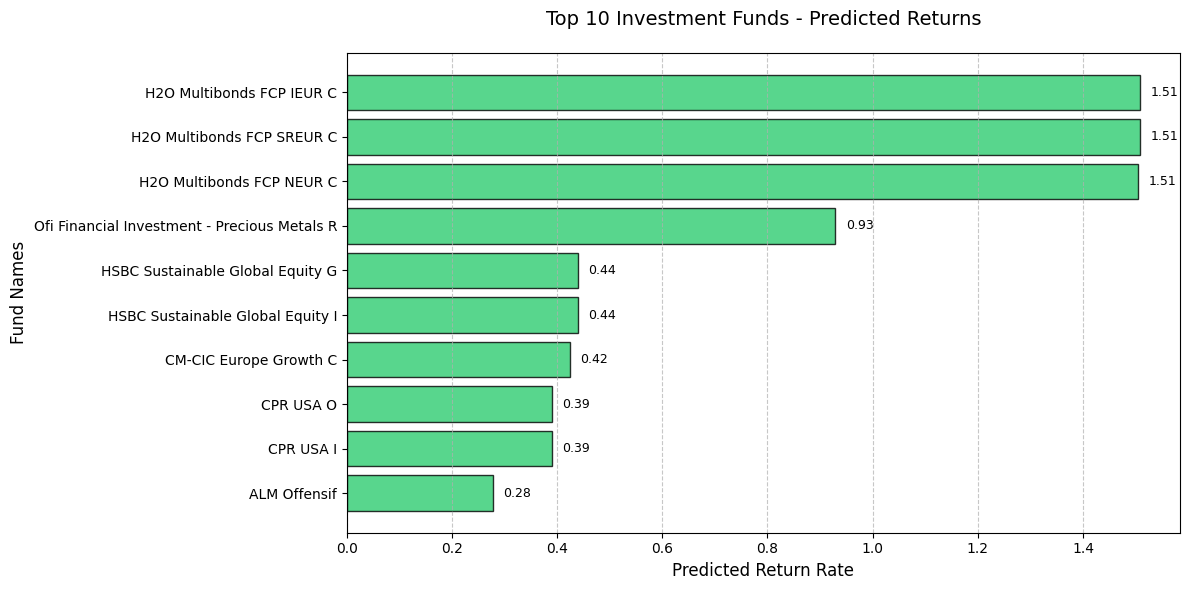


🏆 TOP 10 INVESTMENT FUNDS:
Name                                          Predicted_Chg             Risk                    
                   H2O Multibonds FCP IEUR C 1.5090                    2.02                     
                  H2O Multibonds FCP SREUR C 1.5090                    2.02                     
                   H2O Multibonds FCP NEUR C 1.5050                    2.01                     
Ofi Financial Investment - Precious Metals R 0.9292                    1.26                     
            HSBC Sustainable Global Equity G 0.4389                    0.45                     
            HSBC Sustainable Global Equity I 0.4389                    0.45                     
                      CM-CIC Europe Growth C 0.4236                    0.44                     
                                   CPR USA O 0.3894                    0.43                     
                                   CPR USA I 0.3894                    0.43                     
  

In [16]:


# Convert Total_Assets to numerical values
funds_df['Total_Assets'] = funds_df['Total_Assets'].str.replace('B', '').str.replace('M', '').astype(float)
funds_df['Total_Assets'] = np.where(
    funds_df['Total_Assets'].astype(str).str.contains('B'),
    funds_df['Total_Assets'] * 1e9,
    funds_df['Total_Assets'] * 1e6
)

# Create Risk column (absolute value of Change)
funds_df['Risk'] = funds_df['Chg'].abs()

# Features and target variable
X = funds_df[["Risk", "Total_Assets"]]
y = funds_df["Chg"]  # Target: Change rate

# 2. Model Training & Evaluation

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate performance
y_pred = model.predict(X_test)
print(f"Model Performance:\n- RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}\n- R²: {r2_score(y_test, y_pred):.3f}")

# 3. Full Dataset Prediction

funds_df["Predicted_Chg"] = model.predict(X)


best_funds = funds_df.sort_values("Predicted_Chg", ascending=False).head(10)[["Name", "Predicted_Chg", "Risk"]]


plt.figure(figsize=(12, 6))
bars = plt.barh(
    best_funds["Name"], 
    best_funds["Predicted_Chg"], 
    color='#2ecc71', 
    edgecolor='black', 
    alpha=0.8
)

plt.title('Top 10 Investment Funds - Predicted Returns', fontsize=14, pad=20)
plt.xlabel('Predicted Return Rate', fontsize=12)
plt.ylabel('Fund Names', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().invert_yaxis()  # Display highest return at top

# Add value labels to bars
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + 0.02, 
        bar.get_y() + bar.get_height()/2, 
        f'{width:.2f}', 
        ha='left', 
        va='center',
        fontsize=9
    )

plt.tight_layout()
plt.show()

print("\n🏆 TOP 10 INVESTMENT FUNDS:")
print(best_funds.to_string(index=False, justify='left', col_space=25))